# Аналитика пользователей мобильного приложения по стартапу продуктов питания

**Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.**

**Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?**

**После изучения воронки продаж нужно исследовать результаты A/A и A/B-теста, чтобы проверить, понравились ли пользователям новые шрифты в приложении.**

**Инструкция по выполнению заданий:**

**Шаг 1. Откройте файл с данными и изучите общую информацию**

**Шаг 2. Подготовьте данные**
- Замените названия столбцов на удобные для вас;
- Проверьте пропуски и типы данных. Откорректируйте, если нужно;
- Добавьте столбец даты и времени, а также отдельный столбец дат;

**Шаг 3. Изучите и проверьте данные**
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
- Много ли событий и пользователей вы потеряли, отбросив старые данные?
- Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

**Шаг 4. Изучите воронку событий**
- Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
- Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
- Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
- По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
- На каком шаге теряете больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты?

**Шаг 5. Изучите результаты эксперимента**
- Сколько пользователей в каждой экспериментальной группе?
- Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
- Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
- Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
- Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import math as mth
from plotly import graph_objects as go

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

logs.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [3]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Структура данных:**

- **EventName - название события, object**
- **DeviceIDHash - уникальный идентификатор пользователя, int64**
- **EventTimestamp - время события в формате timestamp, int64**
- **ExpId - номер эксперимента: 246 и 247 - контрольные группы, а 248 - экспериментальная, int64**

## Шаг 2. Подготовьте данные

### Замените названия столбцов на удобные для вас.

**Изменим шрифт столбцов на змеиный:**

In [4]:
def snake_type(data):
    '''
    Функция принимает датафрейм.
    Возвращает список с измененными
    названиями столбцов под змеиный шрифт.
    '''
    columns = []
    for i in data.columns:
        column_name = []
        for j in i:
            if j == ' ':
                column_name.append('_')
            elif j == i[0] and j.isupper():
                column_name.append(str.lower(j))
            elif j.isupper():
                column_name.append(f'_{str.lower(j)}')
            else:
                column_name.append(j)
        columns.append(''.join(column_name))
    return columns

logs.columns = snake_type(logs)

### Проверьте пропуски и типы данных. Откорректируйте, если нужно.

**Тип данных проверен в шаге с открытием файла и изучением данным. Менять тип данных пока-что нет обоснований.**

**Проверяем наличие пропусков:**

In [5]:
logs.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

**Пропуски отсутствуют. Проверим наличие явных дубликатов:**

In [6]:
logs.duplicated().sum()

413

**413 явных дубликатов, это приблизительно 0.17% от всех данных, по этому будет не критично их удалить.**

**Удаляем дубликаты:**

In [7]:
logs = logs.drop_duplicates()

**Проверим наличие неявных дубликатов в уникальных названиях событий:**

In [8]:
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

**Возможные неявные дубликаты отсутствуют.**

### Добавьте столбец даты и времени, а также отдельный столбец дат.

In [9]:
# Столбцец с датой и временем
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')

# Столбец с датой
logs['event_date'] = (pd.to_datetime(logs['event_timestamp'], unit='s')).dt.date

**Проверяем информацию датафрейма после предобработки данных:**

In [10]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_datetime   243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 13.0+ MB


### Вывод по предобработке данных.

- **Шрифт названий столбцов изменён на змеиный;**
- **Пропуски отсутствуют;**
- **Удалены явные дубликаты, возможные неявные дубликаты отсутствуют;**
- **Добавлены столбцы с датой и временем.**

**Структура данных после предобработки:**

- **event_name - название события, object**
- **device_id_hash  - уникальный идентификатор пользователя, int64**
- **event_timestamp  - время события в формате timestamp, int64**
- **exp_id - номер эксперимента: 246 и 247 - контрольные группы, а 248 - экспериментальная, int64**
- **event_datetime - дата и время события, datetime64[ns]**
- **event_date - дата события, object**

## Шаг 3. Изучите и проверьте данные

### Сколько всего событий в логе?

In [11]:
print('Всего событий в логе произошло:', logs['event_name'].count())

print('')

print('Уникальных событий в логе:',
     (logs.pivot_table(index='event_name', aggfunc={'event_name': 'nunique'}))['event_name'].sum())

Всего событий в логе произошло: 243713

Уникальных событий в логе: 5


### Сколько всего пользователей в логе?

In [12]:
print('Всего пользователей в логе:',
     (logs.pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'}))['device_id_hash'].sum())

Всего пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [13]:
print('В среднем всего произошло событий на пользователя:',
    (logs.pivot_table(index='device_id_hash', values='event_name', aggfunc='count'))['event_name'].mean().round())

print('')

print('В среднем произошло уникальных событий на пользователя:',
    (logs.pivot_table(index='device_id_hash', values='event_name', aggfunc='nunique'))['event_name'].mean().round())

В среднем всего произошло событий на пользователя: 32.0

В среднем произошло уникальных событий на пользователя: 3.0


### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

**Находим минимальную и максимальную дату в логе:**

In [14]:
print('Минимальная дата в логе:', logs['event_datetime'].min().date())
print('Максимальная дата в логе:', logs['event_datetime'].max().date())

Минимальная дата в логе: 2019-07-25
Максимальная дата в логе: 2019-08-07


**Строим диаграммы для сравнения, полные ли данные по событиям по группам за весь период:**

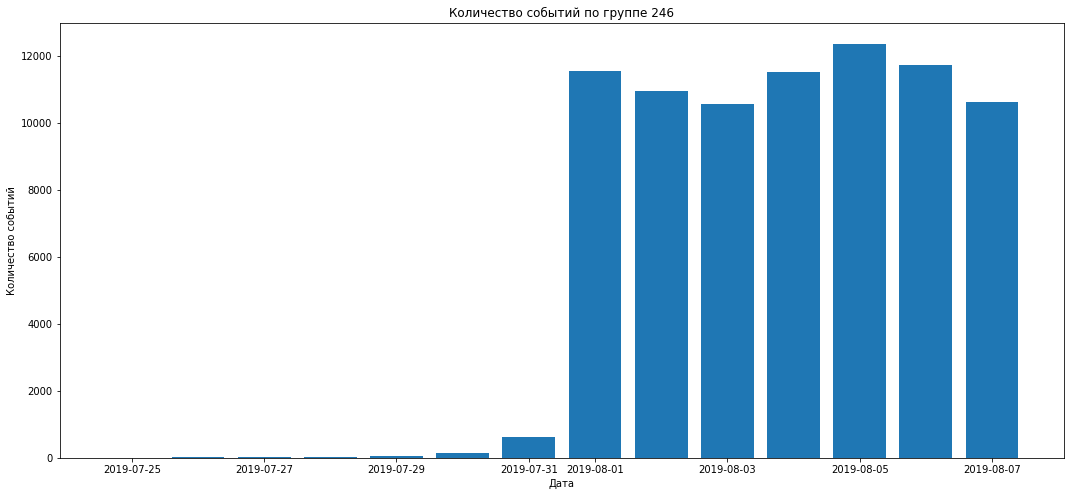

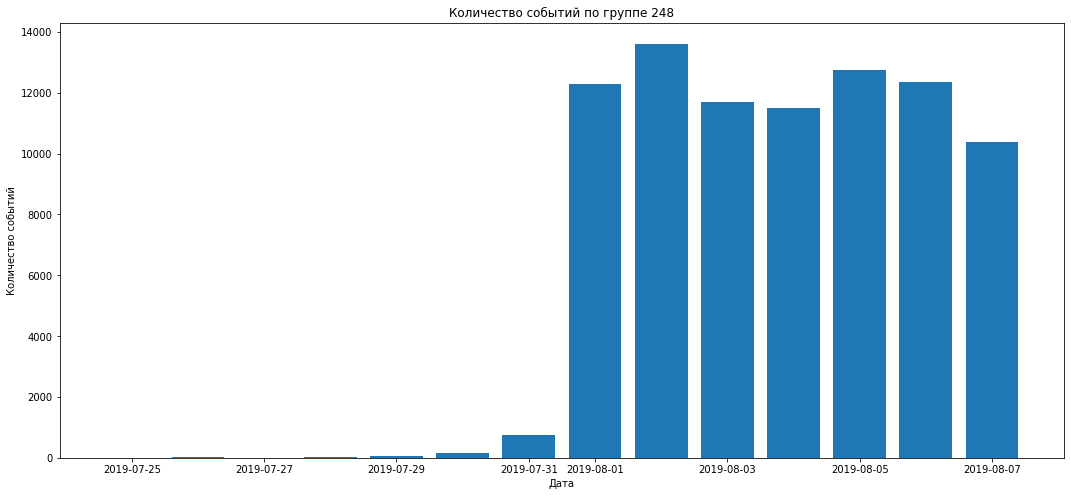

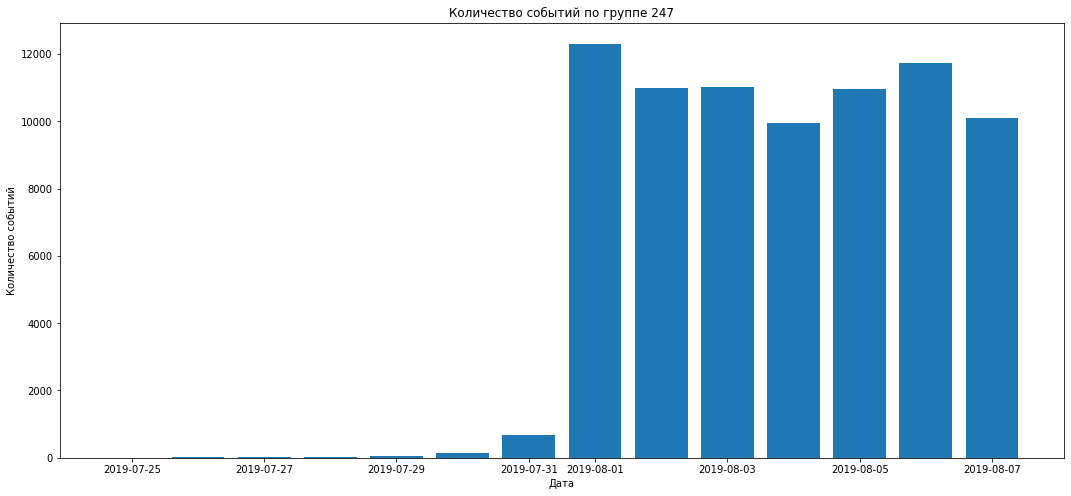

In [15]:
def events_count_bar(group):
    '''
    Функция принимает номер экспериментальной группы;
    Выводит столбчатую диаграмму с распределением количества
    событий по датам.
    '''
    # Группируем данные по дате
    group_events = (logs
                    .query('exp_id == @group')
                    .pivot_table(index='event_date', values='event_name', aggfunc='count'))
    
    # Вывод графика
    plt.figure(figsize=(18, 8))
    plt.bar(group_events.index, group_events['event_name'])
    plt.xlabel('Дата')
    plt.ylabel('Количество событий')
    plt.title(f'Количество событий по группе {group}')
    plt.show()

# Строим графики через функцию
for i in logs['exp_id'].unique():
    events_count_bar(i)

**Событий до 2019-07-31 включительно крайне мало, по сравнению с количеством событий после этой даты.**

**Можно считать полными и актуальными данными все логи, которые произошли от 2019-08-01 включительно.**

**Удаляем неполные данные:**

In [16]:
actual_logs = logs.query('event_datetime >= "2019-08-01 00:00"')

### Много ли событий и пользователей вы потеряли, отбросив старые данные?

In [17]:
# Считаем кол-во событий по сырым и актуальным данным
logs_count = (logs['event_name'].count())
actual_logs_count = (actual_logs['event_name'].count())

# Считаем кол-во пользователей по сырым и актуальным данным
users_count = (logs
               .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
               .sum())
actual_users_count = (actual_logs
                      .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
                      .sum())

# Выводим количества актуальных событий и пользователей
print('Актуальное количество событий:', actual_logs_count)
print('Актуальное количество пользователей:', actual_users_count)

print('')

# Выводим доли
print(f'Доля потерянных событий (всех данных лога): {((logs_count - actual_logs_count) / logs_count * 100).round(2)}%')
print(f'Доля потерянных пользователей: {((users_count - actual_users_count) / users_count * 100).round(2)}%')

Актуальное количество событий: 240887
Актуальное количество пользователей: 7534

Доля потерянных событий (всех данных лога): 1.16%
Доля потерянных пользователей: 0.23%


**Доля потерянных событий не критична, как и доля потерянных пользователей.**

### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [18]:
for i in actual_logs['exp_id'].unique():
    print(f'Кол-во пользователей группы {i}:',
          (actual_logs
          .query('exp_id == @i')
          .pivot_table(index='device_id_hash',
                      aggfunc={'device_id_hash': 'nunique'}))['device_id_hash'].sum())

Кол-во пользователей группы 246: 2484
Кол-во пользователей группы 247: 2513
Кол-во пользователей группы 248: 2537


### Вывод по изучению и проверке данных.

- **Минимальная дата в логе: 2019-07-25**
- **Максимальная дата в логе: 2019-08-07**


- **Всего событий в логе произошло: 243713**
- **Уникальных событий в логе: 5**
- **Всего пользователей в логе: 7551**
- **В среднем всего произошло событий на пользователя: 32**
- **В среднем произошло уникальных событий на пользователя: 3**

**Как видно по столбчатой диаграмме событий по датам, событий до 2019-07-31 включительно крайне мало, по сравнению с количеством событий после этой даты.**

**Можно считать полными и актуальными данными все логи, которые произошли от 2019-08-01 включительно.**

- **Актуальное количество событий: 240887**
- **Актуальное количество пользователей: 7534**


- **Доля потерянных событий: 1.16%**
- **Доля потерянных пользователей: 0.23%**

**Количество пользователей по группам по актуальным данным:**

- **Группа 246: 2484**
- **Группа 247: 2513**
- **Группа 248: 2537**

## Шаг 4. Изучите воронку событий

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.

**Предположим, какие есть события:**

In [19]:
print(logs['event_name'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


- **MainScreenAppear - главный экран;**
- **PaymentScreenSuccessful - страница успешной оплаты;**
- **CartScreenAppear - страница корзины;**
- **OffersScreenAppear - страница с предложением;**
- **Tutorial - страница с обучением, скорее всего обучение интерфейсу.**

**Посмотрим на частоту событий:**

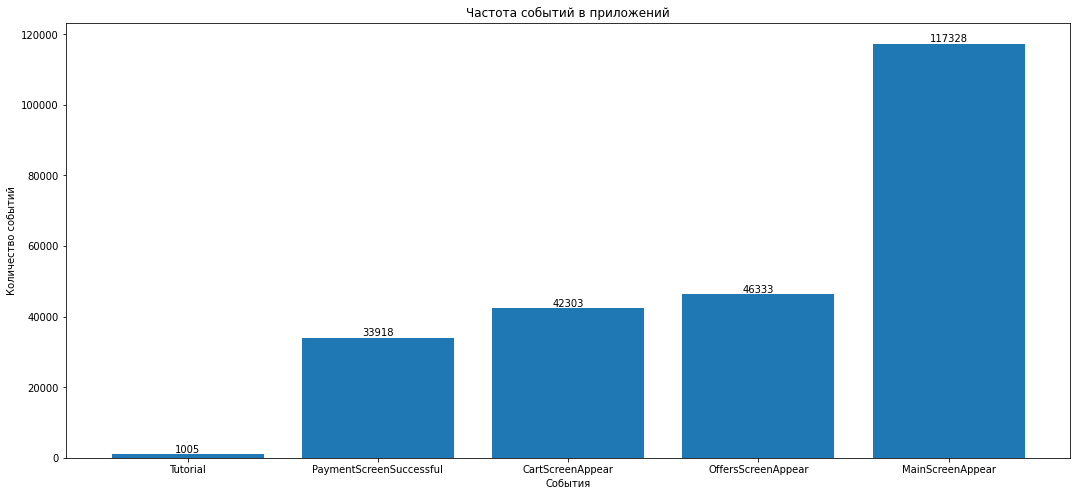

In [20]:
# Группируем кол-во событий по событиям
events_count = (actual_logs
                .pivot_table(index='event_name', aggfunc={'event_name': 'count'})
                .rename(columns={'event_name': 'count'})
                .sort_values(by='count'))

# Вывод графика
plt.figure(figsize=(18, 8))
plt.bar(events_count.index, events_count['count'])
plt.xlabel('События')
plt.ylabel('Количество событий')
plt.title('Частота событий в приложений')
for index, value in enumerate(events_count['count']):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom')
plt.show()

**Пользователи часто отклоняют обучение интерфейсу.**

**По всем событиям открытие страницы с успешной оплатой меньше, чем самих страниц с корзиной или предложением.**

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

**Посмотрим на распределение событий на каждого пользователя и долей пользователя на событие:**

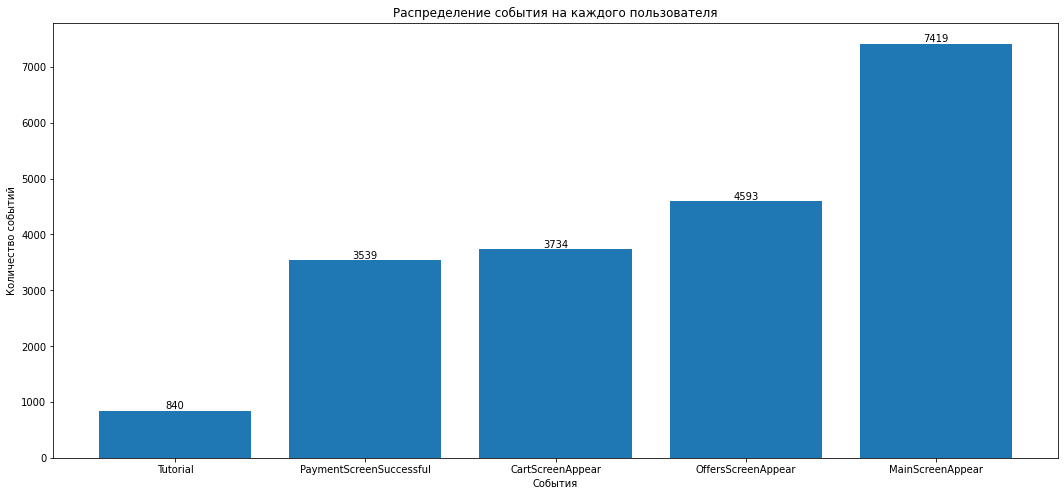

'GitHub не выводит графики plotly.graph_objects, вставлены скриншоты работы этой библиотеки.'

In [21]:
# Группируем данные
events_count_by_users = (actual_logs
                         .pivot_table(index='event_name', values='device_id_hash', aggfunc='nunique')
                         .rename(columns={'device_id_hash': 'count'})
                         .sort_values(by='count'))

# Столбчатая диаграмма с распределением событий на каждого пользователя
plt.figure(figsize=(18, 8))
plt.bar(events_count_by_users.index, events_count_by_users['count'])
plt.xlabel('События')
plt.ylabel('Количество событий')
plt.title('Распределение события на каждого пользователя')
for index, value in enumerate(events_count_by_users['count']):
    plt.text(index, value, str(round(value, 0)), ha='center', va='bottom')
plt.show()

# Удаляем событие Tutorial и сортируем значения в другом порядке
mask = events_count_by_users.loc[events_count_by_users.index == 'Tutorial']
events_count_by_users = (events_count_by_users
                         .drop(index=mask.index)
                         .sort_values(by='count', ascending=False))

# Считаем доли пользователей
events_count_by_users_sum = events_count_by_users['count'].sum()
events_count_by_users['percent'] = (events_count_by_users['count'] / events_count_by_users_sum * 100).round(2)

"""GitHub не выводит графики plotly.graph_objects, вставлены скриншоты работы этой библиотеки."""
## Построение диаграммы воронки
#fig=go.Figure(go.Funnel(
#    y=events_count_by_users.index,
#    x=events_count_by_users['percent']))
#fig.update_layout(
#    title='Доли пользователей в процентах, которые минимум один раз заходили на страницу',
#    yaxis_title='Страницы'
#)
#fig.show()

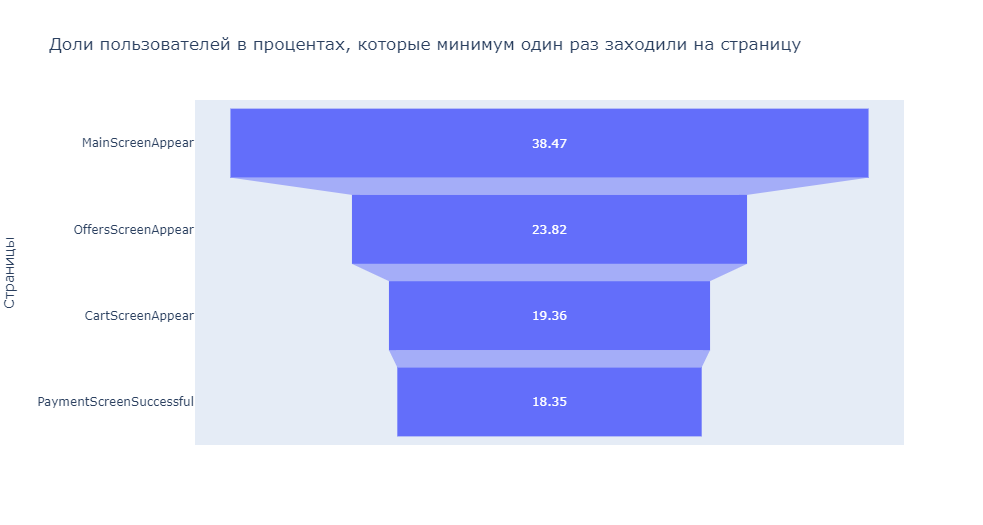

**Пользователи часто отклоняют обучение интерфейсу.**

**Только приблизительно половина из пользователей, которые хоть раз открывали главный экран, доходит до экрана успешной оплаты. Долю таких пользователей мы ещё рассчитаем в этом шаге.**

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.

**Возможны два варианта цепочек событий, как пользователь доходит до экрана с успешной оплатой:**

- **Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты;**


- **Обучение интерфейсу → Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты.**

**Также возможно, что пользователь может заходить на страницы в хаотичном порядке, что может выбивать данные. К примеру, пользователь впервые с главной страницы заходит в корзину, пропуская страницу предложения, выходит из приложения и больше не пользуется им. Это в случае, если система аналитики может фиксировать такой переход.**

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

**Возьмём следующую воронку событий:**

**A → B → C → D**

**Где:**

- **Главный экран - A;**
- **Страница с предложением - B;**
- **Страница корзины - C;**
- **Экран успешной оплаты - D.**

**Обучение интерфейсу брать не будем, так-как большинство пользователей его пропускают, и нам важен путь пользователя до страницы с успешной оплатой.**

In [22]:
main_screen_count = (events_count_by_users.query('index == "MainScreenAppear"')['count']).sum()
offer_screen_count = (events_count_by_users.query('index == "OffersScreenAppear"')['count']).sum()
cart_screen_count = (events_count_by_users.query('index == "CartScreenAppear"')['count']).sum()
payment_screen_count = (events_count_by_users.query('index == "PaymentScreenSuccessful"')['count']).sum()

print(f'Доля пользователей при переходе A → B: {((offer_screen_count / main_screen_count) * 100).round(2)}%')
print(f'Доля пользователей при переходе B → C: {((cart_screen_count / offer_screen_count) * 100).round(2)}%')
print(f'Доля пользователей при переходе C → D: {((payment_screen_count / cart_screen_count) * 100).round(2)}%')

Доля пользователей при переходе A → B: 61.91%
Доля пользователей при переходе B → C: 81.3%
Доля пользователей при переходе C → D: 94.78%


**94.78% пользователей, которые заходили в корзину, оплачивали товар.**

**До самого предложения с главного экрана переходило только 61.91% пользователей. Скорее всего есть проблема в интерфейсе, то что пользователям сложно или не вызывает желания открывать само предложение. Но точно мы пока-что знать не можем.**

### На каком шаге теряете больше всего пользователей?

**На главном экране.**

### Какая доля пользователей доходит от первого события до оплаты?

In [23]:
print(f'Доля пользователей, которая доходит от главной страницы к странице успешной оплаты: \
{((payment_screen_count / main_screen_count) * 100).round(2)}%')

Доля пользователей, которая доходит от главной страницы к странице успешной оплаты: 47.7%


**Как и предполагали, до страницы с успешной оплатой доходит приблизительно половина пользователей.**

**Конверсия 47.7% - хороший показатель. Примерно каждый второй пользователь приложения доходит до успешной оплаты.**

### Вывод по изучению воронки событий.

**В воронке событий есть следующие события:**

- **MainScreenAppear - главный экран;**
- **PaymentScreenSuccessful - страница успешной оплаты;**
- **CartScreenAppear - страница корзины;**
- **OffersScreenAppear - страница с предложением;**
- **Tutorial - страница с обучением, скорее всего обучение интерфейсу.**


**Пользователи часто отклоняют обучение интерфейсу, если сравнить доли открытия главного экрана и открытия обучения.**


**Возможны два варианта цепочек событий, как пользователь доходит до экрана с успешной оплатой:**

- **Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты;**

- **Обучение интерфейсу → Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты.**


**Также возможно, что пользователь может заходить на страницы в хаотичном порядке, что может выбивать данные. К примеру, пользователь впервые с главной страницы заходит в корзину, пропуская страницу предложения, выходит из приложения и больше не пользуется им. Это в случае, если система аналитики может фиксировать такой переход.**


**Доли пользователей при переходе по воронке событий:**
- **Доля пользователей при переходе A → B: 61.91%**
- **Доля пользователей при переходе B → C: 81.3%**
- **Доля пользователей при переходе C → D: 94.78%**

**Где:**

- **Главный экран - A;**
- **Страница с предложением - B;**
- **Страница корзины - C;**
- **Экран успешной оплаты - D.**

**На первом шаге, на переходе с главной страницы на страницу с предложением теряется больше всего пользователей.**


**Доля пользователей, которая доходит от главной страницы к странице успешной оплаты: 47.7%**

## Шаг 5. Изучите результаты эксперимента

### Сколько пользователей в каждой экспериментальной группе?

**Посмотрим количество пользователей в каждой группе, и проверим, чтобы каждый пользователь находился только в одной группе теста:**

In [24]:
# Вывод количества пользователей в каждой группе
for i in actual_logs['exp_id'].unique():
    print(f'Кол-во пользователей группы {i}:',
          (actual_logs
          .query('exp_id == @i')
          .pivot_table(index='device_id_hash',
                      aggfunc={'device_id_hash': 'nunique'}))['device_id_hash'].sum())

print('')

# Проверка наличия пользователей в более чем одной группы
user_per_group = (actual_logs.pivot_table(index='device_id_hash', values='exp_id', aggfunc='nunique'))
non_unique_group = user_per_group.loc[user_per_group['exp_id'] > 1]

if non_unique_group.empty: 
    print('Все пользователи находятся только в одном эксперименте.')
else:
    print('Некоторые пользователи участвуют в более чем одном эксперименте:')
    print(non_unique_group)

Кол-во пользователей группы 246: 2484
Кол-во пользователей группы 247: 2513
Кол-во пользователей группы 248: 2537

Все пользователи находятся только в одном эксперименте.


### Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.

**Проверим разницу количества пользователей в контрольных группах A/A-теста:**

In [25]:
# Считаем количество пользователей по группам
group_246_count = (actual_logs
                   .query('exp_id == 246')
                   .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
                   .sum())
group_247_count = (actual_logs
                   .query('exp_id == 247')
                   .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
                   .sum())

# Выводим разницу количества в процентах
print(f'Различие кол-ва пользователей в группах A/A-теста: \
{((group_247_count - group_246_count) / group_247_count * 100).round(2)}%')

Различие кол-ва пользователей в группах A/A-теста: 1.15%


**Различие составляет более 1%, это может говорить о неудаче A/A-тестов.**

**Проверим с помощью теста с использованием величины z, есть ли статистическая значимость в различии долей пользователей. Формулировка гипотез:**

- **Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 247;**

- **Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 247.**

In [26]:
# Кол-во пользователей в контрольных группах
control_groups_count = group_246_count + group_247_count

# Доли пользователей
p1 = group_246_count / control_groups_count
p2 = group_247_count / control_groups_count

# Объединенные доли
p_combined = (group_246_count * p1 + group_247_count * p2) / (group_246_count + group_247_count)

# Z-величина
z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1 / group_246_count + 1 / group_247_count))

# Задаём стандартное нормальное распределение
distr = st.norm(0, 1)

alpha = 0.05

p_value = (1 - distr.cdf(abs(z_value))) * 2

print(f'P-value:', p_value.round(5))

if p_value < 0.05:
    print('Отклоняем нулевую гипотезу: различие пользователей статистически значимо.')
else:
    print('Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.')

P-value: 0.68163
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.


**Различие по количеству пользователей в контрольных группах A/A-теста есть, но оно не статически значимо.**

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

**Самое популярное событие - главная страница.**

**Считаем кол-во пользователей по главной странице и их доли:**

In [27]:
main_screen_246 = (actual_logs
                   .query('exp_id == 246 and event_name == "MainScreenAppear"')
                   .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
                   .sum())
main_screen_247 = (actual_logs
                   .query('exp_id == 247 and event_name == "MainScreenAppear"')
                   .pivot_table(index='device_id_hash', aggfunc={'device_id_hash': 'nunique'})['device_id_hash']
                   .sum())

main_screen_246_247 = main_screen_246 + main_screen_247

main_screen_246_part = (main_screen_246 / main_screen_246_247 * 100).round(2)
main_screen_247_part = (main_screen_247 / main_screen_246_247 * 100).round(2)

print(f'Кол-во пользователей группы 246, которые минимум 1 раз заходили на главную страницу: {main_screen_246}')
print(f'Кол-во пользователей группы 247, которые минимум 1 раз заходили на главную страницу: {main_screen_247}')

print('')

print(f'Доля пользователей группы 246, которые минимум 1 раз заходили на главную страницу:: {main_screen_246_part}%')
print(f'Доля пользователей группы 247, которые минимум 1 раз заходили на главную страницу:: {main_screen_247_part}%')

Кол-во пользователей группы 246, которые минимум 1 раз заходили на главную страницу: 2450
Кол-во пользователей группы 247, которые минимум 1 раз заходили на главную страницу: 2476

Доля пользователей группы 246, которые минимум 1 раз заходили на главную страницу:: 49.74%
Доля пользователей группы 247, которые минимум 1 раз заходили на главную страницу:: 50.26%


**Проведём тесты о равенстве долях на каждом событий между контрольными группами A/A-теста.**

**Так-как здесь будет проводится множественная проверка гипотез, применим коррекцию к уровню значимости.**

In [28]:
def hypothesis_test(data, group_one, group_two, event_name, alpha=0.05):
    '''
    Функция по рассчету статистической значимости между двумя группами
    по определенному событию.
    
    Функция принимает:
    - data - датафрейм;
    - group_one - название первой группы теста;
    - group_two - название второй группы теста;
    - event_name - название события;
    - alpha - уровень значимости теста (по умлочанию = 0.05).
    
    Выводит через функцию print():
    - Название события;
    - Нулевую и альтернативную гипотезу;
    - Значение P-value;
    - Результат теста.
    '''
    # Количество пользователей по группам на событие
    a_count = data.query('exp_id == @group_one and event_name == @event_name')['device_id_hash'].nunique()
    b_count = data.query('exp_id == @group_two and event_name == @event_name')['device_id_hash'].nunique()

    # Общее количество пользователей по группам
    a_total_count = data.query('exp_id == @group_one')['device_id_hash'].nunique()
    b_total_count = data.query('exp_id == @group_two')['device_id_hash'].nunique()

    # Доли пользователей, которые выполнили событие в каждой группе
    p1 = a_count / a_total_count
    p2 = b_count / b_total_count

    # Объединенная доля
    p_combined = (a_count + b_count) / (a_total_count + b_total_count)

    # Z-величина
    z_value = (p1 - p2) / mth.sqrt(p_combined * (1 - p_combined) * (1 / a_total_count + 1 / b_total_count))

    # Задаём стандартное нормальное распределение
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Событие: {event_name}')
    print(f'Нулевая гипотеза: Доля пользователей группы {group_one} = Доля пользователей группы {group_two}')
    print(f'Альтернативная гипотеза: Доля пользователей группы {group_one} ≠ Доля пользователей группы {group_two}')
    
    print('')
    
    print(f'P-value:', p_value.round(5))
    
    if p_value < alpha:
        print('Отклоняем нулевую гипотезу: различие пользователей статистически значимо.')
    else:
        print('Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.')

def hypothesis_test_call(data, group_one, group_two, alpha=0.05):
    '''
    Функция для вызова функции hypothesis_test. Итерирует
    вызов функции в зависимости от количества событий.
    Исключает событие Tutorial.
    Принимает:
    - Датафрейм;
    - Номер первой группы;
    - Номер второй группы;
    - Уровень значимости теста (по умолчанию = 0.05).
    '''
    for event_name in data['event_name'].unique():
        if event_name == 'Tutorial':
            pass
        else:
            print('')
            print('')
            print('')
            hypothesis_test(data, group_one, group_two, event_name, alpha=alpha_corr)

# Корректированный уровень значимости
alpha_corr = 1-((1-0.05)**(1/16))

print(f'Корректированный уровень значимости: {alpha_corr}')

hypothesis_test_call(actual_logs, 246, 247, alpha_corr)

Корректированный уровень значимости: 0.0032006977101884937



Событие: MainScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 247
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 247

P-value: 0.75706
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: OffersScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 247
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 247

P-value: 0.2481
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: CartScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 247
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 247

P-value: 0.22883
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: PaymentScreenSuccessful
Нулевая гипотеза: Доля

**Группы не различны, A/A-тест работает корректно.**

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

**Проводим тесты контрольнольной группы 246 и эксперементальной 248:**

In [29]:
hypothesis_test_call(actual_logs, 246, 248, alpha_corr)




Событие: MainScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 248

P-value: 0.29497
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: OffersScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 248

P-value: 0.20836
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: CartScreenAppear
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246 ≠ Доля пользователей группы 248

P-value: 0.07843
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: PaymentScreenSuccessful
Нулевая гипотеза: Доля пользователей группы 246 = Доля пользователей группы 248


**Тесты контрольнольной группы 247 и эксперементальной 248:**

In [30]:
hypothesis_test_call(actual_logs, 247, 248, alpha_corr)




Событие: MainScreenAppear
Нулевая гипотеза: Доля пользователей группы 247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 247 ≠ Доля пользователей группы 248

P-value: 0.45871
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: OffersScreenAppear
Нулевая гипотеза: Доля пользователей группы 247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 247 ≠ Доля пользователей группы 248

P-value: 0.91978
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: CartScreenAppear
Нулевая гипотеза: Доля пользователей группы 247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 247 ≠ Доля пользователей группы 248

P-value: 0.57862
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: PaymentScreenSuccessful
Нулевая гипотеза: Доля пользователей группы 247 = Доля пользователей группы 248


**Объединяем контрольные группы 246 и 247 и тестируем с эксперементальной 248:**

In [31]:
# Создаём копию датафрейма actual_logs, в котором номера контрольных групп
# переписаны как '246+247'
actual_logs_test = actual_logs.copy()
actual_logs_test['exp_id'] = (actual_logs_test['exp_id']
                              .astype(str)
                              .replace(['246', '247'], '246+247', regex=True))

# Вызов функции для проведения тестов
hypothesis_test_call(actual_logs_test, '246+247', '248', alpha_corr)




Событие: MainScreenAppear
Нулевая гипотеза: Доля пользователей группы 246+247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246+247 ≠ Доля пользователей группы 248

P-value: 0.29425
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: OffersScreenAppear
Нулевая гипотеза: Доля пользователей группы 246+247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246+247 ≠ Доля пользователей группы 248

P-value: 0.43426
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: CartScreenAppear
Нулевая гипотеза: Доля пользователей группы 246+247 = Доля пользователей группы 248
Альтернативная гипотеза: Доля пользователей группы 246+247 ≠ Доля пользователей группы 248

P-value: 0.18176
Не отклоняем нулевую гипотезу: различие пользователей НЕ статистически значимо.



Событие: PaymentScreenSuccessful
Нулевая гипотеза: Доля пользователей группы 246+247 = До

**Между группами 246, 247 и 248 нет различий по доле пользователей на каждом шаге воронки. Как и между объединенными контрольными группами (246+247) и эксперементальной (248).**

**Продолжать тесты на этих группах нет обоснований.**

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

**Так-как на одних данных была множественная проверка гипотез, была применена коррекция уровня значимости по формуле метода Шидака:**

**a_corr = 1-(1-a)^(1/n)**

**Где:**
- **a - уровень статистической значимости;**
- **n - количество нулевых гипотез.**

**В итоге корректированный уровень значимости получился такой:**

In [32]:
print(f'Корректированный уровень значимости: {alpha_corr}')

Корректированный уровень значимости: 0.0032006977101884937


## Вывод по проделанной работе

### Предобработка данных:

- **Шрифт названий столбцов изменён на змеиный;**
- **Пропуски отсутствуют;**
- **Удалены явные дубликаты, возможные неявные дубликаты отсутствуют;**
- **Добавлены столбцы с датой и временем.**

**Структура данных после предобработки:**

- **event_name - название события, object**
- **device_id_hash  - уникальный идентификатор пользователя, int64**
- **event_timestamp  - время события в формате timestamp, int64**
- **exp_id - номер эксперимента: 246 и 247 - контрольные группы, а 248 - экспериментальная, int64**
- **event_datetime - дата и время события, datetime64[ns]**
- **event_date - дата события, object**


### Изучение и проверка данных:

- **Минимальная дата в логе: 2019-07-25**
- **Максимальная дата в логе: 2019-08-07**


- **Всего событий в логе произошло: 243713**
- **Уникальных событий в логе: 5**
- **Всего пользователей в логе: 7551**
- **В среднем всего произошло событий на пользователя: 32**
- **В среднем произошло уникальных событий на пользователя: 3**

**Как видно по столбчатой диаграмме событий по датам, событий до 2019-07-31 включительно крайне мало, по сравнению с количеством событий после этой даты.**

**Можно считать полными и актуальными данными все логи, которые произошли от 2019-08-01 включительно.**

- **Актуальное количество событий: 240887**
- **Актуальное количество пользователей: 7534**


- **Доля потерянных событий: 1.16%**
- **Доля потерянных пользователей: 0.23%**

**Количество пользователей по группам по актуальным данным:**

- **Группа 246: 2484**
- **Группа 247: 2513**
- **Группа 248: 2537**


### Изучение воронки событий:

**В воронке событий есть следующие события:**

- **MainScreenAppear - главный экран;**
- **PaymentScreenSuccessful - страница успешной оплаты;**
- **CartScreenAppear - страница корзины;**
- **OffersScreenAppear - страница с предложением;**
- **Tutorial - страница с обучением, скорее всего обучение интерфейсу.**


**Пользователи часто отклоняют обучение интерфейсу, если сравнить доли открытия главного экрана и открытия обучения.**


**Возможны два варианта цепочек событий, как пользователь доходит до экрана с успешной оплатой:**

- **Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты;**

- **Обучение интерфейсу → Главный экран → Страница с предложением → Страница корзины → Экран успешной оплаты.**


**Также возможно, что пользователь может заходить на страницы в хаотичном порядке, что может выбивать данные. К примеру, пользователь впервые с главной страницы заходит в корзину, пропуская страницу предложения, выходит из приложения и больше не пользуется им. Это в случае, если система аналитики может фиксировать такой переход.**


**Доли пользователей при переходе по воронке событий:**
- **Доля пользователей при переходе A → B: 61.91%**
- **Доля пользователей при переходе B → C: 81.3%**
- **Доля пользователей при переходе C → D: 94.78%**

**Где:**

- **Главный экран - A;**
- **Страница с предложением - B;**
- **Страница корзины - C;**
- **Экран успешной оплаты - D.**

**На первом шаге, на переходе с главной страницы на страницу с предложением теряется больше всего пользователей.**


**Доля пользователей, которая доходит от главной страницы к странице успешной оплаты: 47.7%**


### Изучение результатов эксперимента:

**Между группами 246, 247 и 248 нет различий по доле пользователей на каждом шаге воронки. Как и между объединенными контрольными группами (246+247) и эксперементальной (248).**

**Продолжать тесты на этих группах нет обоснований.**

**Так-как на одних данных была множественная проверка гипотез, была применена коррекция уровня значимости по формуле метода Шидака:**

**a_corr = 1-(1-a)^(1/n)**

**Где:**
- **a - уровень статистической значимости;**
- **n - количество нулевых гипотез.**


## Рекомендации заказчику

**На первом шаге, на главной странице в воронке теряется больше всего пользователей, на страницу с предложением переходит только 62% пользователей по всем группам. Нужно обратить внимание, что мешает пользователю перейти на следующий шаг воронки - открыть страницу с предложением. Рекомендации:**

- **Провести UX-исследование из пунктов на выбор:**
    - **Usability Testing - проверка, насколько интерфейс удобен. Проверяемым пользователям дают стандартные задачи с интерфейсом, по которым нужно выяснить сложности;**
    - **Eye tracking - изучить визуальное взаимодействие пользователя с интерфейсом с помощью специальных устройств отслеживания взгляда на экране. Может помочь выявить, на что пользователь обращает или не обращает внимание своим взглядом;**
    - **Интервью:**
        - **Экспертное интервью - интервью с экспертами по дизайну, интерфейсу и тематике приложения;**
        - **Проблемное интервью - опрос, который позволяет выявить, есть ли у пользователей определенные потребности.**
    - **Фокус-группа - групповая дискуссия и обсуждение.**


- **Провести новый A/A и A/B-тест с новой эксперементальной группой по новому дизайну и/или интерфейсу. Тесты можно провести на основе UX-исследований, что будет более эффективно.**

**По остальным шагам воронки проходит хорошая доля пользователей - от 80 до 95%.**